In [1]:
import numpy as np
import healpy as hp
import h5py
import matplotlib.pyplot as plt
from sobol_seq import i4_sobol
from tqdm import tqdm

from msfm.utils import files, parameters, input_output
from msfm.grid_pipeline import GridPipeline
from msfm.utils.cosmogrid import get_cosmo_params_info

n_side = 512
n_pix = hp.nside2npix(n_side)

23-07-24 02:23:18    scales.py INF   Setting up healpy to run on 256 CPUs 


### CosmoGrid params

In [2]:
cosmo_params_info = get_cosmo_params_info("../../data/CosmoGridV1_metainfo.h5")
print(cosmo_params_info.dtype)

all_Om = cosmo_params_info["Om"]
all_s8 = cosmo_params_info["s8"]
all_w0 = cosmo_params_info["w0"]
all_sobol = cosmo_params_info["sobol_index"]

[('As', '<f8'), ('bary_Mc', '<f8'), ('bary_nu', '<f8'), ('H0', '<f8'), ('O_cdm', '<f8'), ('O_nu', '<f8'), ('Ob', '<f8'), ('Ol', '<f8'), ('Om', '<f8'), ('m_nu', '<f8'), ('ns', '<f8'), ('s8', '<f8'), ('w0', '<f8'), ('wa', '<f8'), ('delta', 'S128'), ('sobol_index', '<i4'), ('benchmark_type', 'S128'), ('id_param', '<i4'), ('path_par', 'S128'), ('box_size_Mpc_over_h', '<f8'), ('n_particles', '<i8'), ('n_shells', '<i4'), ('n_steps', '<i4')]


### Extended params

In [3]:
conf = files.load_config()
sobol_priors = parameters.get_prior_intervals(
    conf["analysis"]["params"]["sobol"] + conf["analysis"]["params"]["ia"] + conf["analysis"]["params"]["bg"]
)

all_bg = []
all_n_bg = []
for i_sobol in all_sobol:
    sobol_point, _ = i4_sobol(sobol_priors.shape[0], i_sobol)
    sobol_params = sobol_point * np.squeeze(np.diff(sobol_priors)) + sobol_priors[:, 0]
    sobol_params = sobol_params.astype(np.float32)

    Aia = sobol_params[6]
    n_Aia = sobol_params[7]
    bg = sobol_params[8]
    n_bg = sobol_params[9]

    all_bg.append(bg)
    all_n_bg.append(n_bg)

# $\sigma_8 - b_g$ degeneracy

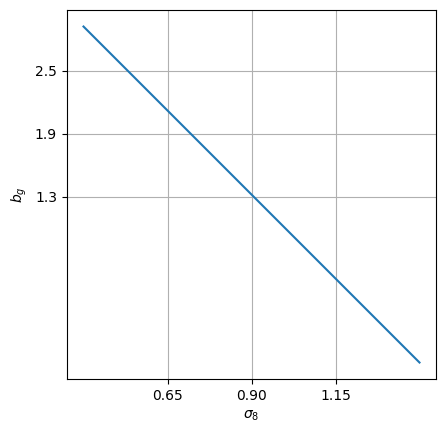

In [4]:
# b_g = -3.2 sigma_8 + 4.2
s8_prior = np.squeeze(parameters.get_prior_intervals(["s8"]))
x = np.linspace(s8_prior[0], s8_prior[1], 50)


fig, ax = plt.subplots()
ax.plot(x, -3.2*x + 4.2)
ax.set_xticks([0.65, 0.9, 1.15])
ax.set_yticks([1.3, 1.9, 2.5])
ax.set_box_aspect(1)
ax.set(xlabel=r"$\sigma_8$", ylabel=r"$b_g$")
ax.grid(True)

In [5]:
assert len(all_Om) == len(all_s8) == len(all_w0) == len(all_bg) == len(all_n_bg)

# degenerate cosmos in the sigma_8, b_g plane
deg_sobol = []
for i, (sobol, Om, s8, w0, bg, n_bg) in enumerate(zip(all_sobol, all_Om, all_s8, all_w0, all_bg, all_n_bg)):
    
    # sigma_8 - b_g degeneracy plane 
    if np.abs(-3.2 * s8 + 4.2 - bg) <= 0.1:

        # Omega_m and w0
        if np.abs(Om - 0.25) <= 0.05 and np.abs(w0 + 1.0) <= 0.1:
            deg_sobol.append(sobol)
            
print(len(deg_sobol))

21


# plots

### loop through all of the grid data

In [6]:
pipeline_kwargs = {
    "with_lensing": False,
    "with_clustering": True,
    "apply_norm": True,
    "with_padding": True,
}
grid_pipe = GridPipeline(**pipeline_kwargs)
data_vec_pix = grid_pipe.data_vec_pix

23-07-24 02:23:23     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-07-24 02:23:23     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


In [7]:
dset_kwargs = {
    "local_batch_size": 16,
    "n_readers": 1,
    "n_prefetch": 1,
}
grid_dset = grid_pipe.get_dset(tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v3/grid/DESy3_grid_???.tfrecord", **dset_kwargs)

23-07-24 02:23:25 grid_pipelin INF   Batching into 16 elements locally 
23-07-24 02:23:25 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23-07-24 02:23:26 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'dg']) 
23-07-24 02:23:26 grid_

In [8]:
# %%time
# data_vectors = []
# cosmos = []
# for data_vector, cosmo, index in tqdm(grid_dset, total=2500):
#     if index[0][0] in deg_sobol:
#         data_vectors.append(data_vector)
#         cosmos.append(cosmo)
        
#         print(f"{len(data_vectors)}/{len(deg_sobol)}: {index[0]}")

In [9]:
# with h5py.File("./s8_bg_degeneracy.h5", "w") as f:
#     f.create_dataset(name="data_vectors", data=data_vectors)
#     f.create_dataset(name="cosmos", data=cosmos)
#     f.create_dataset(name="sobol", data=deg_sobol)


### load the selected cosmologies

In [10]:
with h5py.File("./s8_bg_degeneracy.h5", "r") as f:
    data_vectors = f["data_vectors"][:]
    cosmos = f["cosmos"][:]

# shapes
print(data_vectors.shape)
print(cosmos.shape)
n_cosmos = data_vectors.shape[0]
n_exampels = data_vectors.shape[1]
n_tomo = data_vectors.shape[3]

# sort by sigma_8
i_sort = np.argsort(cosmos[:,0,1])
data_vectors = data_vectors[i_sort]
cosmos = cosmos[i_sort]

(21, 16, 464896, 4)
(21, 16, 10)


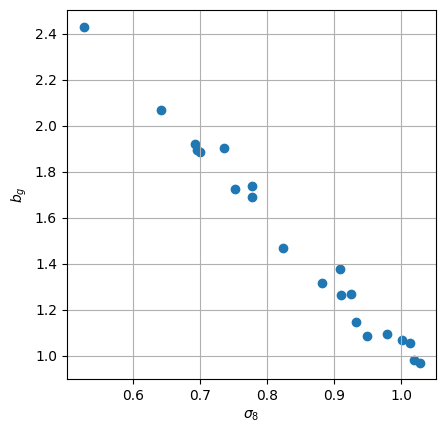

In [11]:
s8 = cosmos[:,0,1]
bg = cosmos[:,0,8]

fig, ax = plt.subplots()
ax.scatter(s8, bg)
ax.set_box_aspect(1)
ax.grid(True)
ax.set(xlabel=r"$\sigma_8$", ylabel=r"$b_g$")
fig.savefig("./s8_bg_degeneracy_points.png", bbox_inches="tight", dpi=300)

In [12]:
i_example = 0
square_pix = 500
reso = 1

gnoms = np.zeros((n_cosmos, n_tomo, 500, 500))

for i in range(n_cosmos):
    for j in range(n_tomo):
        hp_map = np.zeros(n_pix)
        hp_map[data_vec_pix] = data_vectors[i,i_example,:,j]

        gnoms[i,j] = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=square_pix, ysize=square_pix, return_projected_map=True, no_plot=True)
        
gnoms = np.ma.masked_where(gnoms==0, gnoms)

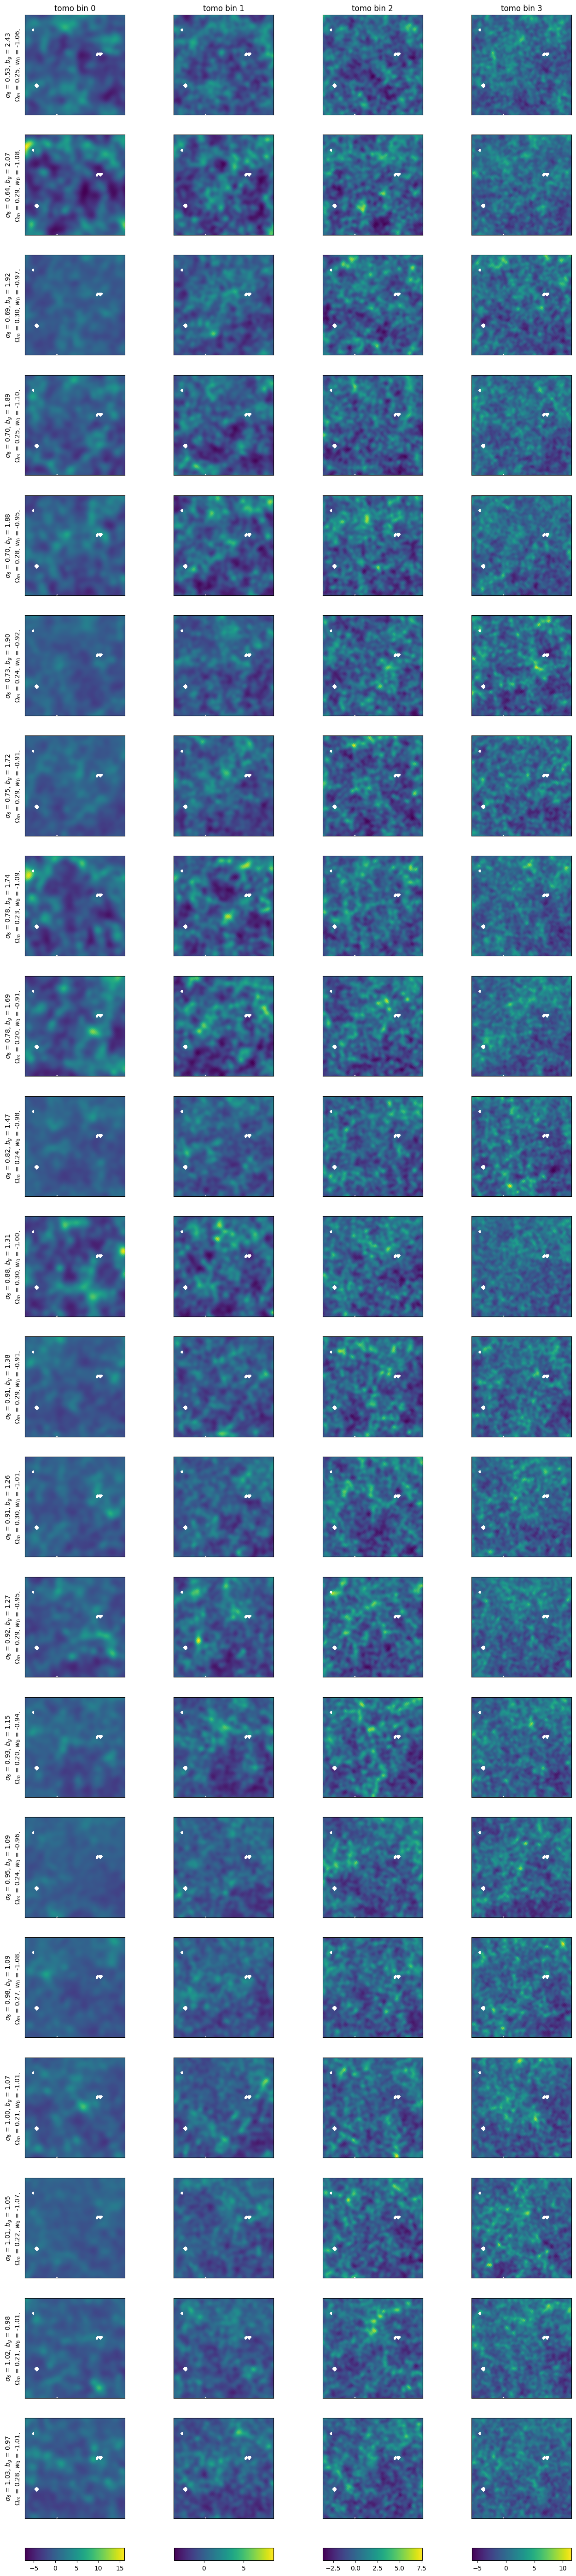

In [13]:
vmin = gnoms.min(axis=(0,2,3))
vmax = gnoms.max(axis=(0,2,3))

fig, ax = plt.subplots(nrows=n_cosmos, ncols=n_tomo, figsize=(n_tomo*4, n_cosmos*4), sharex=True, sharey=True)

for i in range(n_cosmos):
    for j in range(n_tomo):
        im = ax[i,j].imshow(gnoms[i,j], vmin=vmin[j], vmax=vmax[j])
        
        # cosmetics
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
        if i==0:
            ax[i,j].set(title=f"tomo bin {j}")
        
        if i==n_cosmos-1:
            fig.colorbar(im, ax=ax[:,j], orientation="horizontal", shrink=0.8, aspect=8, pad=0.01, location="bottom")
            
        if j==0:
            ax[i,j].set(ylabel=r"$\sigma_8$ = " + f"{cosmos[i,0,1]:.2f}, " + r"$b_g$ = " + f"{cosmos[i,0,8]:.2f}\n" r"$\Omega_m$ = " + f"{cosmos[i,0,0]:.2f}, " + r"$w_0$ = " + f"{cosmos[i,0,5]:.2f}, ")

fig.savefig("./s8_bg_degeneracy_data.png", bbox_inches="tight", dpi=300)